In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Pfad zum Projekt-Root hinzufügen, um das Package 'src' zu finden
# Annahme: Dieses Notebook liegt in src/notebooks/
import sys
from pathlib import Path

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm



In [2]:
# custom imports
PROJECT_ROOT = Path(__file__).resolve().parent.parent.parent if "__file__" in locals() else Path("../../..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.d_eval.evaluation.loader import load_model, load_test_data_v2
from src.d_eval.evaluation.style import apply_shap_style, get_model_style, save_plot, SHAP_BLUE, SHAP_RED

apply_shap_style()

In [3]:
# paths
DATA_DIR = "/Users/robin/PycharmProjects/Masterarbeit_Public/data/parquet/features/asinh1-reg"
VAL_SET_PATH = DATA_DIR + "/splits/val_purged.parquet"
SCALER_PATH = DATA_DIR + "/scaler/scaler.joblib"
MODEL_PATH = "/Users/robin/PycharmProjects/Masterarbeit_Public/models/Lasso_LargeScale.joblib"

# figures
FIGURES_DIR = "figures/lasso"

# target
TARGET_COL = "label_5min"
THINNING_FREQ_MIN = 5

# data
TTD_MINUTES_MIN = 30
TTD_MINUTES_MAX = 300

In [4]:
# load data
X_test_scaled, y_test_scaled = load_test_data_v2(
    VAL_SET_PATH,
    target_col=TARGET_COL,
    keep_id_cols=True,
    sample_minutes=THINNING_FREQ_MIN
)

# extract product keys for later use
product_keys = X_test_scaled['delivery_start']
snapshot_times = X_test_scaled['snapshot_times']
ttd_min = (product_keys - snapshot_times).dt.total_seconds() / 60

# drop id cols from features
X_test = X_test_scaled.drop(columns=['delivery_start', "snapshot_times"])

print("-" * 30)
print(f"Anzahl Test-Samples (nach Downsampling): {len(y_test_scaled):,}")

Memory usage of dataframe is 1496.47 MB
Memory usage after optimization is: 1450.66 MB
Decreased by 3.1%
Downsampling (Relativ 5min): Von 4,002,956 auf 142,153 Zeilen reduziert.
No TTD clipping applied.
------------------------------
Anzahl Test-Samples (nach Downsampling): 142,153


In [5]:
# load model
model = load_model(MODEL_PATH)

/opt/anaconda3/envs/Masterarbeit/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator Lasso from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


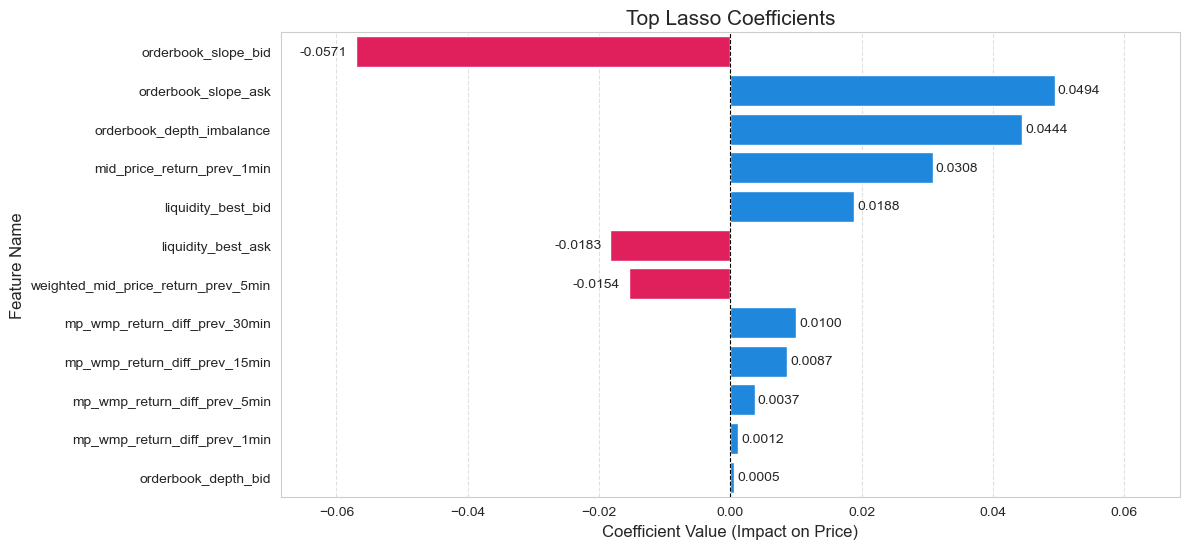

✅ Grafik gespeichert in: figures/lasso/lasso_coefficients.png


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_coefficients(model, feature_names, filter_non_zero_coeff=True, top_n=20, title="Top Lasso Coefficients",
                      save_name=None):
    """
    Visualisiert die Top-N Koeffizienten eines linearen Modells (SGD).
    Unterscheidet farblich zwischen positiven (treibenden) und negativen (dämpfenden) Effekten.
    """

    # 1. Koeffizienten extrahieren
    # Bei SGDRegressor sind die Gewichte in .coef_ gespeichert
    coefs = model.coef_.flatten()

    # Check, ob Feature-Namen zur Anzahl der Koeffizienten passen
    if len(coefs) != len(feature_names):
        print(f"WARNUNG: Anzahl Features ({len(feature_names)}) != Anzahl Koeffizienten ({len(coefs)})")
        # Fallback: Generische Namen nutzen, falls es nicht passt
        feature_names = [f"Feature_{i}" for i in range(len(coefs))]

    # 2. DataFrame erstellen
    df_coefs = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs,
        'Abs_Coefficient': np.abs(coefs)  # Hilfsspalte für Sortierung nach Stärke
    })

    # 3. Top-N stärkste Features (nach Betrag) auswählen
    df_coefs = df_coefs[df_coefs['Abs_Coefficient'] != 0] if filter_non_zero_coeff else df_coefs
    df_top = df_coefs.sort_values(by='Abs_Coefficient', ascending=False).head(top_n)

    # 4. Plotten
    fig = plt.figure(figsize=(12, len(df_top) * 0.3 + 2))

    # Farbcodierung: Rot für negativ, Grün/Blau für positiv
    colors = [SHAP_RED if x < 0 else SHAP_BLUE for x in df_top['Coefficient']]

    sns.barplot(
        data=df_top,
        x='Coefficient',
        y='Feature',
        palette=colors,
        hue='Feature',  # Workaround für Seaborn Future Warning
        legend=False
    )

    # set x limits
    max_coef = max(df_top['Abs_Coefficient'])
    plt.xlim(-max_coef * 1.2, max_coef * 1.2)

    plt.title(title, fontsize=15)
    plt.xlabel("Coefficient Value (Impact on Price)", fontsize=12)
    plt.ylabel("Feature Name", fontsize=12)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)  # Nulllinie
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # Werte an die Balken schreiben
    for i, v in enumerate(df_top['Coefficient']):
        offset = max(df_top['Coefficient']) * 0.01 if v >= 0 else -max(df_top['Abs_Coefficient']) * 0.15
        plt.text(v + offset, i, f"{v:.4f}", va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    if save_name:
        save_plot(fig, save_name, FIGURES_DIR)

    return df_coefs.sort_values(by="Coefficient", ascending=False)  # Gibt die volle Tabelle zurück


# --- ANWENDUNG ---

# Feature Namen aus deinem DataFrame (Beispiel)
feature_names = X_test.columns.tolist()

# Falls dein SGD Modell direkt in einer Variable liegt:
all_coefs = plot_coefficients(model, feature_names, save_name="lasso_coefficients.png")